# HPC Minichallenge 1 - HS22

## Teil 1

### Aufgabe 1.4

In Kafka wird primär über vordefinierte Schnittstellen (Producer / Consumer) kommuniziert. Nutzer organisieren ihre Daten hierbei innerhalb von Topics. Kafka erlaubt es beim Erstellen neuer Topics die Anzahl an Partitionen als auch den Replikationsfaktor zu definieren. Der Replikationsfaktor bestimmt herbei, wie oft die Daten auf den verfügbaren Nodes dupliziert werden. Die Anzahl an Partitionen sind relevant, wenn es um die Parallelisierbarkeit der Schnittstellen geht.  Die genaue Verteilung der Daten in den Partitionen als auch die Aufteilung der Partitionen in einzelne Nodes organisiert Kafka eigenständig. Beim Monitoring via Kafdrop ist für jede Partition die Leader Node ersichtlich als auch die Priorität der Replikation Nodes. Das Abschalten einzelner Docker Container hat keinen grösseren Einfluss auf die Funktionsfähigkeit von Kafka, sofern der Replikationsfaktor genügend hoch gewählt ist. Solange mindestens eine Replikation in Kafka aktiv ist, ist es möglich weiterhin Informationen zu schreiben und abzugreifen. Der Kafka Zookeeper vergibt automatisch die ausgefallenen Leader auf die verfügbaren Replikation Nodes. Werden nun Partitionen auf Nodes durch das Wiedereinschalten von Containern erneut verfügbar, bleiben diese scheinbar als Leader Nodes disqualifiziert. 

### Aufgabe 1.7


#### Daten: 
Die live Bewertungen werden durch den bestehenden Datensatz **Toys_and_Games_5.json** simuliert. Dieses ist einem Subset des Amazon Review Dataset von Ni Jianmo welches unter dem folgenden URL erreichbar ist: 
https://nijianmo.github.io/amazon/index.html

#### Scenario: 
Ein Onlinehändler möchte auf seiner Webseite neu ein Live-Feed implementieren, mit dem Ziel, die Kunden dazu zu ermutigen mehr Produkte anzusehen. Dafür sollen im Live-Feed jeweils die fünf trendigen Produkte der letzten Minute mit den aktuellsten Kundenratings angezeigt werden. 
Für die Umsetzung möchte er die bereits bestehende Datenmanagement-Infrastruktur nutzen, in dem Ratings mittels Apache Kafka strukturiert werden. 
Diese ist in *Abbildung 1* aufgeführt.

![Schema_1.png](Schema_1.png)

#### Struktur:

Das Kafka Environment ist auf verschiedene Images verteilt. Dieses beinhaltet das Kafka Cluster bestehend aus den drei Broker images *broker1*, *broker2* und *broker3*, als auch dem Zookeper *zookeper*, welcher die Kommunikation und Datenstrukturierung unter den Broker organisiert und in einem separaten Image läuft. Als zusätzlicher Mikroservice fürs Monitoring steht, das Kafdrop web UI zur Verfügung, welches über ein weiteres image *kafdrop1* ausgeführt wird.

Im *jupyter1* Container wird sämtlicher in Python geschriebener Code ausgeführt.
Hier befinden sich auch die vier Notebooks, von welchen der gesammte Prozess gesteuert werden kann.

- **Producer_1.ipynb** simuliert die live Bewertungen der Kunden. Hierfür werden mit einer definierbaren Frequenz > 1 Hz einzelne Bewertungen aus dem Toys_and_Games_5.json gelesen und zu Kafka unter dem Topic `live_ratings` gesendet. 

- **Consumer_1.ipynb** erhält alle live Bewertungen, welche auf Kafka unter dem Topic  `live_ratings` publiziert wurden. In Kombination mit einem Datasink werden in minütlichen Abständen die Anzahl an Bewertungen pro Produkt als auch die durchschnittliche Produktbewertung errechnet und abgespeichert.

- **Producer_2.ipynb** überprüft, ob neue Durchschnittsbewertungen vorhanden sind und publiziert jeweils die fünf Produkte mit den häufigsten Bewertungen auf ein neues Kafka Topic `top_ratings`.

- **Consumer_2.ipynb** erhält die fünf  meist bewerteten Produkte aus dem Topic `top_ratings` und zeigt diese live als Barplot an.

#### Verbesserungespotential

Zukünftig können die einzelnen Scripts auf mehrere Container verteilt werden. Dadurch wäre es möglich, diese auf unterschiedliche Systeme laufen zu lassen.

### 1. Bonusaufgabe:

Ursprünglich wurden die Bewertungen im JSON Format gesendet. Diese Funktionalität wird nun in einem nächsten Schritt mit Google Protobuf implementiert. Protobuf ist ein binäres Format, welches besonders geeignet ist, wenn ein hochperformanter Datenaustausch von strukturell ähnlichen Nachrichten benötigt wird. Da wir durchgehend strukturell identische Informationen senden, eignet sich dieses Format auch gut für unseren Anwendungsfall.


Um die Daten mit Protobuff senden zu können, musste zuerst die Struktur der Nachricht in einem proto File definiert werden. Für meinen Anwendungsfall benötigte ich drei verschiedene Nachrichten, welche im **message_struc.proto** File hinterlegt sind:
1. `Rating`:  Einzelne Ratings von Kunden.
2. `AverageRating`: Einzelne durchschnittliche Bewertung von Produkten.
3. `AverageRatings`: Kollektion an durchschnittliche Bewertung von Produkten.

Anschliessend wurde mit einem von Protobuf zur Verfügung gestellten Compilers das **message_struc_bp2.py** File erstellt, wodurch die einzelnen Formate in Python als Klassenobjekt importiert und verwendet werden können. 

- Der Compiler wurde über das folgende GitHub Repository heruntergeladen: [https://github.com/protocolbuffers/protobuf/releases](https://github.com/protocolbuffers/protobuf/releases) 

- Der Befehl zum kompilieren lautet: `protoc -I=. --python_out=. message_struc.proto`




## Teil 2

### Aufgabe 2.1

In diesem Schritt wird RabbitMQ als weiterer Message Broker hinzugefügt. 

Dafür wurde in einem ersten Schritt das **docker-compose.yml** angepasst. Hier wurde ein neuer Container *rabbitmq1* erstellt, welcher das rabbitmq:3.8-management-alpine image von docker-hub herunterlädt. Der Zusatz "Management" bedeutet hier, dass wir über einen zusätzlichen Port automatisch ein UI mitgeliefert erhalten, welches zum Monitoren verwendet werden kann. Dieses ist via [localhost:15672](localhost:15672) erreichbar

"Alpine" bedeute hingegen legidlich, dass es sich um die speichereffiziente Variante handelt.

Weiter wurden die bestehenden Klassen und ihre Methoden im **helper_file.py** angepasst und erweitert, sodass nun einfach zwischen Kafka und RabbitMQ gewechselt werden kann.

### Aufgabe 2.2

Nachfolgend in Visualisierung 2 ist nun die Implementation des Message Brokers mittels RabbitMQ visualisiert. 

![Schema_2.png](Schema_2.png)


Anders als bei der Implementation mit Kafka wird hier aktuell nur ein weiterer Container genutzt, über welchen das ganze Message-Broker System läuft. Es ist jedoch auch mit RabbitMQ möglich ein Cluster mit mehreren Containern zu erstellen. Der *jupyter1* Container bleibt im Vergleich zur vorherigen Implementation unverändert. 

### Aufgabe 2.3

RabbitMQ kommuniziert standardmässig mit dem binären AMQP-0.9.1 Protokoll, wobei auch noch andere Protokolle unterstützt werden. Siehe [www.rabbitmq.com/protocols](https://www.rabbitmq.com/protocols.html#:~:text=AMQP%200%2D9%2D1%20is%20the,protocol%20used%20by%20RabbitMQ%20tutorials) 

RabbitMQ selbst funktioniert als pub-sub Kommunikationspattern. Die Daten werden beim publishen mit RabbitMQ zuerst auf eine Exchange gesendet, wobei es mehrere Arten von Exchanges gibt. Ich nutze den Exchange-Typ `Direkt`, was bedeutet, dass unter Verwendung eines Message-Routing-Schlüssel Nachrichten von der Exchange kopiert und die Kopien direkt zu einer Queue hinzugefügt werden.

Alternative Exchange-Typen wären:
- `Topic`: Hier werden Nachrichten basierend auf sub-strings einer oder auch mehreren Queues zugeordnet. Dabei muss die Queue gleich heissen wie der relevante Sub-string.

- `Fanout`: Verteilt alle Nachrichten an alle an eine Exchange gebundene Exchange. Der Message-Routing-Schlüssel wird hier ignoriert.

- `Header`: Gleich wie Topic, aber anstelle des Message-Routing-Schlüssels werden hier Informationen aus dem Header der Nachricht fürs Routing verwendet. 

Anschliessend können die Queues über den passenden Message-Routing-Schlüssel wieder abgerufen werden. Wird vom Nutzer keine Exchange definiert, wird standardmässig eine immer vorhandene Standard-Exchange `""` verwendet.

#### Kafka vs RabbitMQ
Da RabbitMQ mit Queues arbeitet, werden Nachrichten, nachdem sie konsumiert wurden und eine Bestätigung zum Konsum gesendet wurde, auch tatsächlich gelöscht. Kafka hingegen kann auch als Queue genutzt werden, die dahinterliegende Speicherarchitektur ist jedoch deutlich flexibler und die Lebensdauer von Daten in Kafka wird durch eine Policy festgelegt. Während Kafka mit dem Zookeeper einen grossen Teil der Speicherverwaltung selbst übernimmt, kann bei RabbitMQ das exakte Datenrouting in der Applikation festgelegt werden, als auch Prioritäten im Datenfluss definiert werden.



#### Weitere Kommunikationsarten: 
*System-to-system*: Hierbei handelt es sich um einen traditionellen Ansatz, in dem kein weiterer Message-Broker dazwischen fungiert. Zwar bietet diese Methode für kleine Systeme mit nur sehr wenigen Akteuren an. Sie ist jedoch erstens relativ langsam, da der Sender nicht mehr Daten produzieren sollte als Empfänger verarbeiten kann, da sonst Datenverlust droht. Und zweitens ist diese Variante nur schlecht skalierbar, da für jeden weiteren Akteur im Netz eigene Schnittstellen programmiert werden müssen, was schnell exponentiell Skaliert.

#### Praktikabilität des Kommunikationspattern 
Ich bin der Meinung, dass das gewöhnliche pup-sub Kommunikationspattern mit RabbitMQ nur teilweise geeignet ist, da die Ratings nach dem Konsum gelöscht werden und vom Webshop ein Interesse bestehen sollte, Produktbewertungen Persistent aufzubewahren. In diesem Falle wäre also die Verwendung von Kafka als Message-Broker definitiv sinnvoller. 

## Teil 3


In [1]:
import numpy as np
import snakeviz
from IPython.utils import io
from memory_profiler import profile
import time
import shutil
import os

import Producer_1
import Producer_2
import Consumer_1_and_Datasink
import Consumer_2_and_Datasink

### Zeitmessung Producer

Für die Zeitmessung der Producer wird die künstliche Wartezeit mittels `time.sleep()` zwischen dem Senden einzelner Bewertungen auf ein Minimum reduziert. Die Zeitmessung erfolgt mit der IPython Magic Funktion. Für das

#### Producer 1

In [3]:
%%timeit
with io.capture_output() as captured:
    Producer_1.run("rabbitmq", 10, hz=10e9)

15.8 ms ± 300 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
%%timeit
with io.capture_output() as captured:
    Producer_1.run("rabbitmq", 100, hz=10e9)

83.3 ms ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Das Ausführen des Producer 1 inklusive dem senden von 10 Ratings benötigt im Schnitt zwischen 55 und 56 Millisekunden.

Das Ausführen des Producer 1 inklusive dem senden von 100 Ratings benötigt im Schnitt rund 334 Millisekunden.

Unter der Annahme, dass wir einen Fixen Zeitaufwand für das Initialisieren des Producers haben und einen Skallierbaren mit der Anzahl an zu sendenen Nachrichten, dann ergibt sich der folgende Dreisatz:

In [5]:
x = np.array([[1, 10], [1, 100]])
y = np.array([16, 84])
i, s = np.linalg.solve(x, y)
print(f"Mit diesem Resultat ist zu erwarten, dass der Producer 1 für die Initialisierung um die {round(i, 3)} Millisekunden benötigt.")
print(f"Der Code zum Senden einer Bewertung skaliert entsprechend um die {round(s, 3)} Millisekunden pro zu sendende Nachricht.")

Mit diesem Resultat ist zu erwarten, dass der Producer 1 für die Initialisierung um die 8.444 Millisekunden benötigt.
Der Code zum Senden einer Bewertung skaliert entsprechend um die 0.756 Millisekunden pro zu sendende Nachricht.


#### Producer 2

Für den Producer 2 Test muss zuerst eine ausreichende Anzahl an CSV's im  *src/datasink* vorhanden sein. Deshalb wird in einem nächsten Schritt ein zufälliges CSV aus dem *src/datasink/archive* Ordner kopiert und vervielfacht abgespeichert.

In [6]:
def create_test_files(path, n_copies):
    '''Creates a defined number of testfiles in a specified path'''
    for file in os.listdir("src/datasink/archive/"):
        if str(file).endswith(".csv"):
            for i in range(n_copies):
                shutil.copy(path + file, path + file.replace(".csv", "") + "_test" + str(i) + ".csv")
            return
        
def retrieve_from_archive():
    '''Copies retrieves files from the datasink archive folder'''
    for file in os.listdir("src/datasink/archive/"):
        if str(file).endswith(".csv"):
            if "_test" in file:
                os.replace("src/datasink/archive/" + str(file), "src/datasink/" + str(file))
        
def destroy_test_files(path):
    '''Destroys all testfiles in a specified path'''
    for file in os.listdir(path):
        if str(file).endswith(".csv"):
            if "_test" in file:
                os.remove(path + file)


In [7]:
# create test files
path =  "src/datasink/archive/"
n_copies = 50
create_test_files(path, n_copies)

In [8]:
# retrieve test files from archive for producer 2
retrieve_from_archive()

In [9]:
%%timeit -r 5 -n 1
with io.capture_output() as captured:
    Producer_2.run("rabbitmq", 5, hz=10e9)

273 ms ± 54.3 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [10]:
# retrieve test files from archive for producer 2
retrieve_from_archive()

In [11]:
%%timeit -r 5 -n 1
with io.capture_output() as captured:
    Producer_2.run("rabbitmq", 10, hz=10e9)

The slowest run took 4.77 times longer than the fastest. This could mean that an intermediate result is being cached.
354 ms ± 180 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


Das Ausführen des Producer 2 inklusive dem senden von 5 top-5-rated-products Listen benötigt im Schnitt um die 435 Millisekunden.

Das Ausführen des Producer 2 inklusive dem senden von 10 top-5-rated-products Listen benötigt im Schnitt um die 547 Millisekunden.

In [12]:
x = np.array([[1, 5], [1, 10]])
y = np.array([273, 354])
i, s = np.linalg.solve(x, y)
print(f"Mit diesem Resultat ist zu erwarten, dass der Producer 1 für die Initialisierung um die {round(i, 3)} Millisekunden benötigt.")
print(f"Der Code zum Senden einer Bewertung skaliert entsprechend um die {round(s, 3)} Millisekunden pro zu sendende Nachricht.")

Mit diesem Resultat ist zu erwarten, dass der Producer 1 für die Initialisierung um die 192.0 Millisekunden benötigt.
Der Code zum Senden einer Bewertung skaliert entsprechend um die 16.2 Millisekunden pro zu sendende Nachricht.


In [13]:
path =  "src/datasink/archive/"
destroy_test_files(path)

### Consumer Profiling 
Für das Profiling der Consumer wurde primär die `snakeviz` Library verwendet.

In [14]:
%load_ext snakeviz

In [15]:
# %snakeviz Consumer_1_and_Datasink.run(framework="rabbitmq", n=330)

In [16]:
# %snakeviz Consumer_2_and_Datasink.run(framework="rabbitmq", n=10)

Die drei nachfolgenden Screenshots zeigt das Profiling des Consumer 1 für das Konsumieren von 330 Nachrichten. Dieser konsumiert die live_bewertungen von RabbitMQ und erstellt jede Minute ein Dataframe mit den Top bewerteten Produkten. 

Das Errechnen und Abspeichern der Top Bewertungen ist hier jedoch Profiling beinhaltet. Zwar benötigt die Funktion zum das Errechnen und Abspeichern der Top-5 Bewertungen im Datasink Erwartungsgemäss am meisten Zeit, da diese Funktion jedoch nur einmal pro Minute benötigt wird, sollte dies bei meinem aktuellen Datenfluss keinen alzu grossen Einfluss haben.

Beim Betrachten des Profilings sehen wir, dass der grösste Teil der Ausführzeit in der in der `Consumer.consume` methode verbracht wird. Diese Beinhaltet drei Methoden `start_consuming`, `basic_consume` und `queue_declare`. Dabei wird con der ausführreihenfolge zuerst mit `queue_declare` eine Queue auf RabbitMQ erstellt. Anschliessend wird mit `basic_consume` Verbindung zur Queue hergestellt. Zuletzt werden mit `start_consuming` über pika's blocking_connection die Nachrichten von RabbitMQ konsummiert. Dieser Schritt dauert am längsten, da der Thread in dieser Methode bleibt bis ein abbruchkriterium erfüllt ist. Innerhalb der Blockingconnection wird zudem die `callback` Methode zm Verarbeiten der Daten und der Datasink lokalisiert.

### Consumer 1
Die drei nachfolgenden Screenshots zeigt das Profiling des Consumer 1 für das Konsumieren von 330 Nachrichten. Dieser konsumiert die live Bewertungen von RabbitMQ und erstellt jede Minute ein Dataframe mit den bestbewerteten Produkten. 

Das Errechnen und Abspeichern der top Bewertungen ist hier jedoch Profiling beinhaltet. Zwar benötigt die Funktion zum Errechnen und Abspeichern der top Bewertungen im Datasink erwartungsgemäss am meisten Zeit, da diese Funktion jedoch nur einmal pro Minute benötigt wird, sollte dies bei meinem aktuellen Datenfluss keinen allzu grossen Einfluss haben.

Beim Betrachten des Profilings sehen wir, dass der grösste Teil der Ausführzeit in der `Consumer.consume` Methode verbracht wird. Diese beinhaltet drei Methoden `start_consuming`, `basic_consume` und `queue_declare`. Dabei wird von der Ordnung der Ausführung zuerst mit `queue_declare` eine Queue auf RabbitMQ erstellt. Anschliessend wird mit `basic_consume` Verbindung zur Queue hergestellt. Zuletzt werden mit `start_consuming` über pika's blocking_connection die Nachrichten von RabbitMQ konsumiert. Dieser Schritt dauert am längsten, da der Thread in dieser Methode bleibt, bis ein Abbruchkriterium erfüllt ist. Innerhalb der Blockingconnection wird zudem die `callback` Methode zum Verarbeiten der Daten und der Datasink lokalisiert.

![Consumer_1.png](Consumer_1.png)

### Consumer 1 - `basic_consume()`

![Consumer_1_basic_consume.png](Consumer_1_basic_consume.png)

### Consumer 1 - `queue_declare()`

![Consumer_1_queue_declare.png](Consumer_1_queue_declare.png)

### Consumer 2

Beim Profiling des Consumer 2 sehen wir, beim Konsumieren von 10 Top-5 Bewertungstabellen, dass ein noch grösserer Teil der Laufzeit als beim Consumer 1 für das Konsumieren der Nachrichten mit der `start_consuming` Methode verbracht wird. Das macht Sinn, da es sich diese Methode in einem Loop befindet, bis entweder eine definierte Anzahl Nachrichten konsumiert wurde oder alle Nachrichten konsumiert wurden. `start_consuming` Methode sehen wir, dass sich die Laufzeit grösstenteils und fast zu gleichen Teilen auf die Funktionen `sink_data` Methode aus dem Datasink und der `close` Methode zum Schliessen der Verbindung am Ende des Konsums aufteilen. Die `sink_data` Methode ruft die `__plot_ranking` Methode auf, welche jeweils immer einen Plot mit den Top-5 Bewertungen generiert. Diese Visualisierung benötigt einen kumulierten Zeitaufwand von 282 Millisekunden. Die 'close' Methode zum Beenden der Verbindung zu RabbitMQ benötigt fast gleich viel Zeit mit 244 Millisekunden. Wieso dieser Schritt so lange dauert, ist mir nicht genau klar.

![Consumer_2.png](Consumer_2.png)

#### Memory Usage

Nachfolgend wird mit `memory_profiler` die Auslastung des Arbeitsspeichers beim Ausführen der Methoden untersucht.

In [17]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [18]:
%%mprun -f Producer_1.run
Producer_1.run('rabbitmq', 1)

Setup rabbitmq connection
0 ratings sent.



Filename: /home/jovyan/Producer_1.py

Line #    Mem usage    Increment  Occurrences   Line Contents
     7    151.1 MiB    151.1 MiB           1   def run(framework='rabbitmq', n=None, hz=5):
     8                                             
     9    151.1 MiB      0.0 MiB           1       topic = "live_ratings"
    10    151.1 MiB      0.0 MiB           1       file = "src/json/Toys_and_Games_5-short.json"
    11                                             
    12    151.1 MiB      0.0 MiB           1       if framework == 'kafka':
    13                                                 producer_1 = Producer(framework='kafka', host_name="broker1", port=9093)
    14                                             
    15    151.1 MiB      0.0 MiB           1       if framework == 'rabbitmq':
    16    151.1 MiB      0.1 MiB           1           producer_1 = Producer(framework='rabbitmq', host_name="rabbitmq1", port=5672)
    17                                             
    18    151

In [19]:
%%mprun -f Producer_2.run 
Producer_2.run('rabbitmq', 1)

Setup rabbitmq connection
File: src/datasink//2022_10_26_16_04_37.csv published



Filename: /home/jovyan/Producer_2.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    23    151.1 MiB    151.1 MiB           1   def run(framework='rabbitmq', n=None, hz=1/10):
    24                                             
    25    151.1 MiB      0.0 MiB           1       topic = "top_ratings"
    26    151.1 MiB      0.0 MiB           1       path = "src/datasink/"
    27                                             
    28    151.1 MiB      0.0 MiB           1       if not os.path.exists(path+"archive/"):
    29                                                 os.makedirs(path+"archive/")
    30                                             
    31    151.1 MiB      0.0 MiB           1       if framework == 'kafka':
    32                                                 producer_2 = Producer(framework='kafka', host_name="broker1", port=9093)
    33                                             
    34    151.1 MiB      0.0 MiB           1       if framework == 'rab

In [20]:
%%mprun -f Consumer_1_and_Datasink.run
Consumer_1_and_Datasink.run('rabbitmq', 1)

Filename: /home/jovyan/Consumer_1_and_Datasink.py

Line #    Mem usage    Increment  Occurrences   Line Contents
     7    151.5 MiB    151.5 MiB           1   def run(framework='rabbitmq', n=1):
     8    151.5 MiB      0.0 MiB           1       topic = "live_ratings"
     9                                             
    10    151.5 MiB      0.0 MiB           1       datasink_1 = DataSink_1(path="./src/datasink/")
    11                                             
    12    151.5 MiB      0.0 MiB           1       if framework == 'kafka':
    13                                                 consumer_1 = Consumer(datasink_1, framework='kafka', host_name="broker1", port=9093)
    14                                             
    15    151.5 MiB      0.0 MiB           1       if framework == 'rabbitmq':
    16    151.5 MiB      0.0 MiB           1           consumer_1 = Consumer(datasink_1, framework='rabbitmq', host_name="rabbitmq1", port=5672)
    17                             

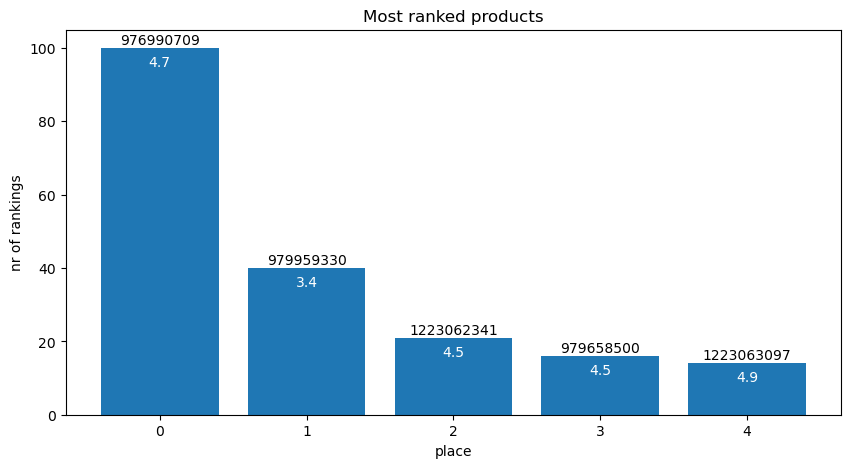

Filename: /home/jovyan/Consumer_2_and_Datasink.py

Line #    Mem usage    Increment  Occurrences   Line Contents
     7    152.7 MiB    152.7 MiB           1   def run(framework="rabbitmq", n=1):
     8    152.7 MiB      0.0 MiB           1       topic = "top_ratings"
     9                                             
    10    152.7 MiB      0.0 MiB           1       datasink_2 = DataSink_2(path="./src/datasink/")
    11                                             
    12    152.7 MiB      0.0 MiB           1       if framework == 'kafka':
    13                                                 consumer_2 = Consumer(datasink_2, framework='kafka', host_name="broker1", port=9093)
    14                                             
    15    152.7 MiB      0.0 MiB           1       if framework == 'rabbitmq':
    16    152.7 MiB      0.0 MiB           1           consumer_2 = Consumer(datasink_2, framework='rabbitmq', host_name="rabbitmq1", port=5672)
    17                              

In [21]:
%%mprun -f Consumer_2_and_Datasink.run
Consumer_2_and_Datasink.run('rabbitmq', 1)

### 3. Bonusaufgabe

Der Onlineshop hat seit kurzer Zeit vermehrt Probleme mit Fake-Bewertungen. Aus diesem Grund wurde eine weitere Funktion programmiert, welche im Producer 1 die Bewertungen auf ihre Echtheit überprüft. Unterhalb wird diese dummy Funktion `check_data()` implementiert, welche pro Bewertung einmal ausgeführt werden soll.

In [22]:
def check_data():
    '''
    Checking data needs some time :)
    This is a placeholder function that creates a bottleneck
    '''
    sum([i for i in range(10**7)])

In [23]:
%%timeit
check_data()

535 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Das Ausführen dieser Methode dauert pro Bewertung ~ 0.5 Sekunden. Da im Schnitt jedoch ca. fünf Bewertungen pro Sekunde generiert werden, führt das zu einem Bottleneck im Producer.

#### Single Thread

In [24]:
import json
import time
from helper_file import Producer
from message_struc_pb2 import Rating
   
topic = "live_ratings_bn"
file = "src/json/Toys_and_Games_5.json"
hz = 5
send_n_ratings = 30
producer_1 = Producer(framework='rabbitmq', host_name="rabbitmq1", port=5672)

Setup rabbitmq connection


In [25]:
%%time
with open(file) as f:
    for i, line in enumerate(f):
        message = json.loads(line)
        check_data()                                        # bottleneck
        rating = Rating()
        rating.reviewerID = str(message["reviewerID"])
        rating.asin = str(message["asin"])
        rating.overall = int(message["overall"])
        rating.reviewText = str(message["reviewText"])
        
        producer_1.produce(topic, message=rating)
        if i % (hz*10) == 0:
            print(f"{i} ratings sent.")
        time.sleep(1/hz)
        
        if i+1 == send_n_ratings:
            print(f"Finished sending {i+1} Ratings ")
            break

0 ratings sent.
Finished sending 30 Ratings 
CPU times: user 11 s, sys: 4.86 s, total: 15.8 s
Wall time: 21.9 s


Mit der ursprünglichen Implementation des Producer 1 dauert das Publizieren von 30 Bewertungen nun über 21 Sekunden. Unser Producer kann den kontinuierlichen Zustrom an neuen Bewertungen also nicht mehr adäquat verarbeiten. Nachfolgend wird deshalb der Producer Überarbeitet, sodass einzelne Arbeitsschritte in mehreren Threads ausgeführt werden können.

#### Multiple Threads

Unter der verwendung von Pythons `threading` Library ist es nun möglich, die Überprüfung des Codes mit mehreren Threads auszuführen. Der ursprüngliche Code des Producers wurde in die `MultiprocessProducer` Klasse integriert und so angepasst, dass der Producer nun aus den folgenden drei Methoden besteht:
- `get_ratings`: Lädt die Bewertungen aus dem Datensatz
- `check_ratings`: Überprüft die Bewertungen mit unserer Methode. 
- `publish_ratings`: Publiziert die überprüften Bewertungen zum Message Broker.

Die `check_ratings` Methode beinhaltet unser Bottleneck und wird mit mehreren Threads ausgeführt.

In [26]:
from queue import Queue, Empty
from threading import Lock, Thread, get_ident
from multithread_producer import MultithreadProducer
            
    
topic = "live_ratings_bn_mp"
file = "src/json/Toys_and_Games_5.json"
hz = 5
send_n_ratings = 30
n_threads = 6
producer_1 = Producer(framework='rabbitmq', host_name="rabbitmq1", port=5672)
multithread_producer = MultithreadProducer(producer_1, file, hz, send_n_ratings)

Setup rabbitmq connection


In [27]:
%%time
get_ratings = Thread(target=multithread_producer.get_ratings)
get_ratings.start()

check_ratings = []
for i in range(n_threads):
    t = Thread(target=multithread_producer.check_ratings)
    t.start()
    check_ratings.append(t)
       
publish_ratings = Thread(target=multithread_producer.publish_ratings, args=(topic,))
publish_ratings.start()

# Properly close threads again
get_ratings.join()
for i in range(n_threads):
    check_ratings[i].join()
publish_ratings.join()

get_ratings: Running on thread 140111877822016
check_ratings: Running on thread 140111863510592
check_ratings: Running on thread 140111855117888
check_ratings: Running on thread 140111846725184
check_ratings: Running on thread 140111496869440
check_ratings: Running on thread 140111488476736
check_ratings: Running on thread 140111480084032
publish_ratings: Running on thread 140111471691328
0 ratings sent.
5 ratings sent.
10 ratings sent.
15 ratings sent.
20 ratings sent.
CPU times: user 11.5 s, sys: 2.9 s, total: 14.4 s
Wall time: 15.2 s


Wir sehen, dass unsere Methoden auf unterschiedlichen Threads ausgeführt wurden. Diese werden in Python jedoch nur Konkurrent ausgeführt und nicht parallel und laufen somit auf derselben CPU-Core. Die Laufzeit des Codes wird deshalb nur minimal schneller. In einem nächsten Schritt passen wir unsere Klasse so an, dass die Methoden nun mit Pythons `multiprocessing` Library ausgeführt werden können.

#### Multiple Processes

Die Klasse zur Ausführung des Producers mittels Multithreading wurde nun in einer neuen MultiprocessProducer Klasse gespeichert. Unter der verwendung von `multiprocessing` in Python werden die einzelnen Prozesse nun tatsächlich auf unterschiedlichen CPU-Cores ausgeführt. Deshalb wird auch eine deutliche Reduktion der Laufzeit erwartet.

In [28]:
from multiprocessing import Queue, Process
from threading import get_ident
from multiprocess_producer import MultiprocessProducer

    
topic = "live_ratings_bn_mp"
file = "src/json/Toys_and_Games_5.json"
hz = 5
send_n_ratings = 30
n_processes = 6
producer_1 = Producer(framework='rabbitmq', host_name="rabbitmq1", port=5672)
multiprocess_producer = MultiprocessProducer(producer_1, file, hz, send_n_ratings)

Setup rabbitmq connection


In [29]:
%%time
get_ratings = Process(target=multiprocess_producer.get_ratings)
get_ratings.start()

check_ratings = []
for i in range(n_processes):
    p = Process(target=multiprocess_producer.check_ratings)
    p.start()
    check_ratings.append(p)
       
publish_ratings = Process(target=multiprocess_producer.publish_ratings, args=(topic,))
publish_ratings.start()

# Properly close threads again
get_ratings.join()
for i in range(n_threads):
    check_ratings[i].join()
publish_ratings.join()

get_ratings: Running on thread 140114374428480
check_ratings: Running on thread 140114374428480
check_ratings: Running on thread 140114374428480
check_ratings: Running on thread 140114374428480
check_ratings: Running on thread 140114374428480
check_ratings: Running on thread 140114374428480
check_ratings: Running on thread 140114374428480
publish_ratings: Running on thread 140114374428480
0 ratings sent.
5 ratings sent.
10 ratings sent.
15 ratings sent.
20 ratings sent.
25 ratings sent.
CPU times: user 66 ms, sys: 76.9 ms, total: 143 ms
Wall time: 6.32 s


Unter der Verwendung der multiprocessing Library dauert das Publizieren von 30 Bewertungen nur noch rund 6 Sekunden. Wenn wir uns erinnern, dass wir 30 Bewertungen bei einer Frequenz 5 Bewertungen pro Sekunde senden wollen, dann erwarten wir ohne die Beeinträchtigung der `check_data()` Funktion eine Laufzeit von ca. 6 Sekunden. Somit wurde das Bottleneck durch die Parallelisierung von `check_data()` erfolgreich behoben.

## Teil 4


In [ ]:
Reflektion: 